(139, 244)
Subjects in two modalities match
First column: X17Networks_LH_VisCent_ExStr_1
(should be 'X17Networks_LH_VisCent_ExStr_1')
Last column: CAU.lh (should be 'CAU.lh)
NPT:  ['MMSE', 'ABETA', 'PTAU', 'TAU', 'AV45', 'CDRSB', 'ADAS13', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan']
--- svr ---
On average, predicted age of 3_interaction_multip differed by -1.080861044794705 years from their chronological age.
MAE = 2.5257765345537435, R2 = 0.5912482469809957
Orange color representing ADNI, purple color representing OASIS
OASIS:
MAE = 3.3791110578496313, R2 = 0.04828313462039002
ADNI:
MAE = 2.046375116971784, R2 = 0.7553147736960583


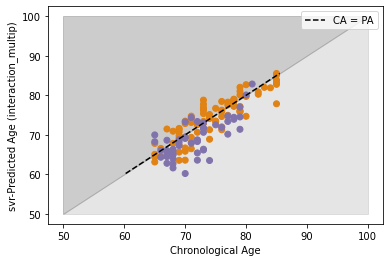

3.855518777213205 0.132199471155392 -0.7269701680906827


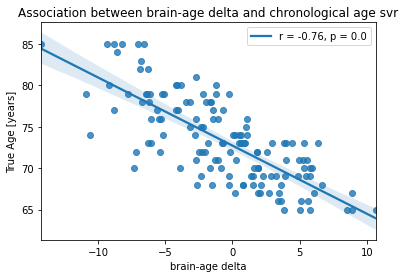

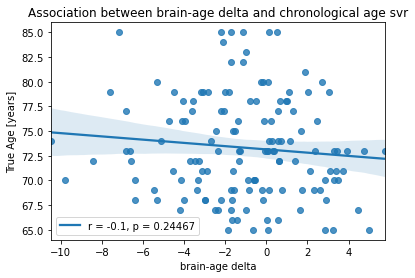

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec  3 11:02:12 2021
*
@author: doeringe
"""
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

import pickle

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score

import plots
import neuropsychology_correlations
# %%
# matplotlib config
cm_all = pickle.load(open("../data/config/plotting_config.p", "rb"))

# %%
# LOAD DATA
# load and inspect data, set modality
# TODO: stratify by age group (young old, middle old, oldest-old)
# modality = input("Which modality are you analyzing? ")
modality = 'interaction_multip'
database = "3_interaction_multip"
mode = "test"
mri = pd.read_csv('../data/ADNI/test_train_PET.csv')
pet = pd.read_csv('../data/ADNI/test_train_MRI.csv')

mri_test = mri[mri['train'] == False]
pet_test = pet[pet['train'] == False]
mri_test = mri_test.reset_index()
pet_test = pet_test.reset_index()
print(mri_test.shape)
# check that all IDs are the same
if pet_test['name'].equals(mri_test['name']):
    print("Subjects in two modalities match")

col = mri.columns[4:-23].tolist()
npt = mri.columns[-19:-2]
print("First column: {}".format(col[0]) +
      "\n(should be 'X17Networks_LH_VisCent_ExStr_1')" +
      "\nLast column: {}".format(col[-1]) +
      " (should be 'CAU.lh)")
print("NPT: ", npt.tolist())

df_test = pd.DataFrame(pet_test[col].values*mri_test[col].values,
                        columns=col, index=pet_test.index)
df_test = pd.concat([df_test, mri_test.drop(col, axis=1)], axis=1)
df_test = df_test.reset_index(drop=True)
db_test = df_test['Dataset'].tolist()

final_model = ['svr' if modality == 'PET' else 'svr' if modality == "MRI" else "svr"][0]

# during cross-validation, gb was best for PET
# and rvr was best for MRI
model_all = pickle.load(open('../results/' + database +
                             '/model_{}_{}.p'.format(
    final_model, modality), "rb"))
intercept_ = model_all['intercept']
slope_ = model_all['slope']
model_ = model_all['model']


# %%
# TESTING

X_test = df_test[col]
y_true = df_test['age'].values

# plot model predictions against GT in test set
y_pred = model_.predict(X_test)
#y_pred_bc = (y_pred - intercept_)/slope_
y_pred_bc = y_pred - (slope_*y_true + intercept_)


# %%
plots.real_vs_pred_2(y_true, y_pred_bc, final_model, modality,
                     mode, database, db_test)

print(mean_absolute_error(y_true,y_pred),
      r2_score(y_true,y_pred),
      np.mean(y_pred-y_true))

# %%
# CHECK BIAS
plots.check_bias(y_true, y_pred, final_model, "{}_test".format(modality),
                 database=database)

plots.check_bias(y_true, y_pred_bc, final_model, "{}_test".format(modality),
                 database=database, corrected=True)

# %%
# SAVE RESULTS
# Create table of (corrected) predicted and chronological age in this modality
# rvr had better performance in both MAE and R2 --> take rvr as final model
y_diff = y_pred_bc - y_true
pred_csv = pd.concat((df_test["name"],
                      pd.DataFrame(y_true, columns=["age"]),
                      pd.DataFrame(y_pred, columns=["RawPredAge"]),
                      pd.DataFrame(y_pred_bc, columns=["CorrPredAge"]),
                      pd.DataFrame(y_diff, columns=["BPAD"])), axis=1)

pred_csv.to_csv('../results/pred_age_{}_{}.csv'.format(modality, final_model))


In [8]:
print(np.min(y_diff), np.max(y_diff))

-10.492747814071208 5.787815624121734


Significant correlations between BPAD and Neuropsychology


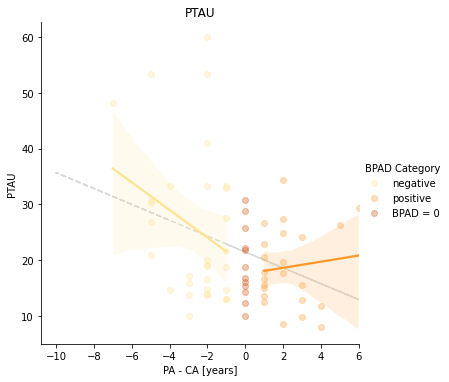

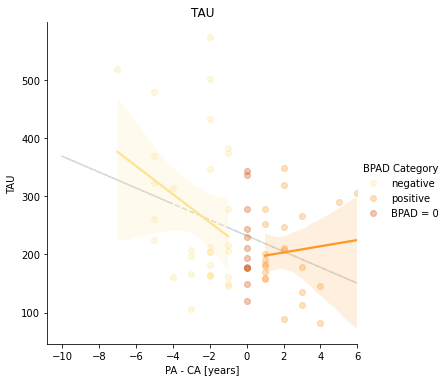

PTAU : -0.338
TAU : -0.339
PTAU significant in positive BPAD:  False  (0.0879729264625948, 0.6897821726372295) 
significant in negative BPAD:  False  (-0.3408084586906668, 0.060631555494909284)
TAU significant in positive BPAD:  False  (0.07875318187692246, 0.7209568913789953) 
significant in negative BPAD:  False  (-0.33848212966438085, 0.06252577204520096)
PTAU significant in amyloid positives:  True  (-0.5572023881304282, 0.002534455183652617) 
significant in amyloid negatives:  False  (0.22159171542121556, 0.17518184583440466)


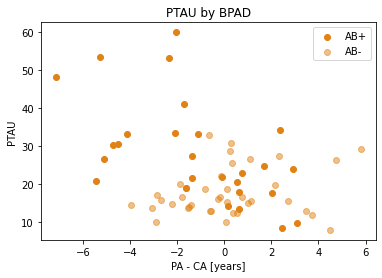

TAU significant in amyloid positives:  True  (-0.5675139542798162, 0.0020194638523646138) 
significant in amyloid negatives:  False  (0.17649840180751922, 0.2824479355485858)


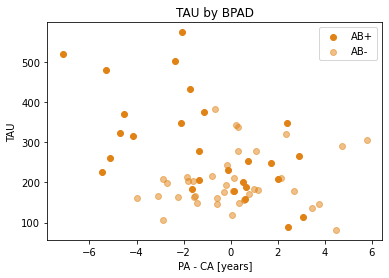

In [7]:
# %%
# CORRELATION NEUROPSYCHOLOGY - BRAIN AGE
# Inspect correlation of neuropsychological scores and predicted/corrected
# brain age
npt = df_test.columns[-19:-2].values

sign_npt = neuropsychology_correlations.neuropsych_correlation(df_test['age'], y_pred_bc,
                                                               "BPAD",
                                                               npt,
                                                               df_test,
                                                               modality,
                                                               database)

# %%
# INTERACTION EFFECTS WITH BPAD
for k in sign_npt:
    exc = np.isnan(df_test[k])
    pos = df_test['BPAD Category'] == 'positive'
    neg = df_test['BPAD Category'] == 'negative'
    
    pos_bool = np.array(~exc) & np.array(pos)
    neg_bool = np.array(~exc) & np.array(neg)
    pearson_pos = stats.pearsonr(y_diff[pos_bool],
                                 df_test[k][pos_bool])
    pearson_neg = stats.pearsonr(y_diff[neg_bool],
                                 df_test[k][neg_bool])
    print(k, "\033[1msignificant in positive BPAD: ", pearson_pos[1] < 0.05,
          "\033[0m", pearson_pos,
          "\n\033[1msignificant in negative BPAD: ", pearson_neg[1] < 0.05,
          "\033[0m", pearson_neg)
# %%
# interaction with amyloid status?

for k in sign_npt:
    exc = np.array(np.isnan(df_test[k]))
    pet_exc = np.isnan(df_test['AV45'])
    pet_pos = df_test['AV45'] >= 1.11
    pet_neg = df_test['AV45'] < 1.11
    pet_pos = np.array(pet_pos) & np.array(~pet_exc)
    pet_neg = np.array(pet_neg) & np.array(~pet_exc)

    csf_exc = np.isnan(df_test['ABETA'])
    csf_pos = df_test['ABETA'] < 977
    csf_neg = df_test['ABETA'] >= 977
    csf_pos = np.array(csf_pos) & np.array(~csf_exc)
    csf_neg = np.array(csf_neg) & np.array(~csf_exc)

    pos_bool = pet_pos | csf_pos & ~(pet_neg | csf_neg)
    neg_bool = pet_neg | csf_neg & ~(pet_pos | csf_pos)

    pearson_pos = stats.pearsonr(y_diff[pos_bool & np.array(~exc)],
                                 df_test[k][pos_bool  & np.array(~exc)])
    pearson_neg = stats.pearsonr(y_diff[neg_bool  & np.array(~exc)],
                                 df_test[k][neg_bool  & np.array(~exc)])
    print(k, "\033[1msignificant in amyloid positives: ", 
          pearson_pos[1] < 0.05,
          "\033[0m", pearson_pos,
          "\n\033[1msignificant in amyloid negatives: ", 
          pearson_neg[1] < 0.05,
          "\033[0m", pearson_neg)
    plt.scatter(y_diff[pos_bool & np.array(~exc)],
                df_test[k][pos_bool  & np.array(~exc)],
                color=cm_all[0], alpha=1, label="AB+")
    plt.scatter(y_diff[neg_bool & np.array(~exc)],
                df_test[k][neg_bool  & np.array(~exc)],
                color=cm_all[0], alpha=0.5, label="AB-")
    plt.xlabel("PA - CA [years]")
    plt.ylabel(k)
    plt.title("{} by BPAD".format(k))
    plt.legend()
    plt.show()

In [ ]:
# %%
# PERMUTATION IMPORTANCE
pi = permutation_importance(model_,
                            X_test, y_true,
                            n_repeats=1000)


# %%
plots.permutation_imp(pi, final_model, modality, database)
